In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
#import tensorflow as tf
#import keras


In [2]:
train_data = pd.read_csv("training_data\mnist_train.csv")

In [3]:
train_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


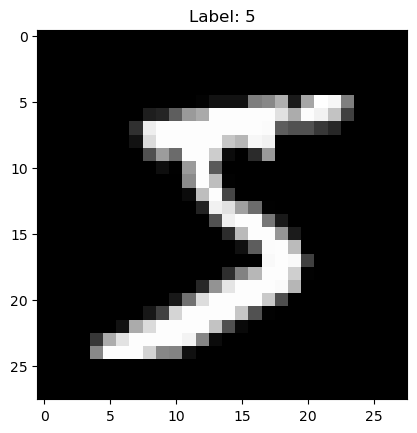

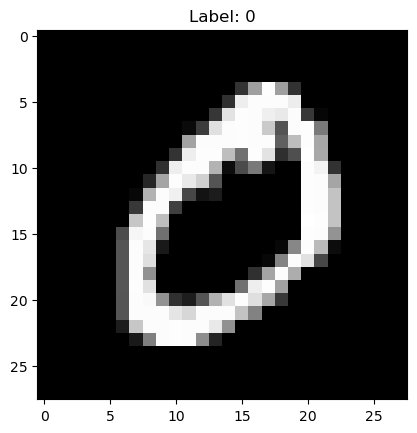

In [4]:
row_to_display = train_data.iloc[0, 1:]
row_to_display2 = train_data.iloc[1, 1:]

image_matrix = np.array(row_to_display).reshape(28, 28)

plt.imshow(image_matrix, cmap='gray')
plt.title(f"Label: {train_data.iloc[0, 0]}")
plt.show()

image_matrix2 = np.array(row_to_display2).reshape(28, 28)

plt.imshow(image_matrix2, cmap='gray')
plt.title(f"Label: {train_data.iloc[1, 0]}")

plt.show()

### Bibliotek

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import tensorflow as tf

import keras.backend as K
print(f"TensorFlow: {tf.version}")
tf.compat.v1.disable_eager_execution()

print(f"TensorFlow: {tf.version}")


TensorFlow: <module 'tensorflow._api.v2.version' from 'c:\\Users\\frykm\\anaconda3\\envs\\tf\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>
TensorFlow: <module 'tensorflow._api.v2.version' from 'c:\\Users\\frykm\\anaconda3\\envs\\tf\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


In [6]:
def projected_gradient_descent(model, x, target_class_id, max_iter, step_size, eps, clamp= (0, 255)):
    """Utför PGD på en bild

    Parametrar:
    model (tf.Tensor()): modellen som skall luras
    x (np.array()): bilden som skall missklassifieras
    target_class_id (int): id:et på klassen som funktionen skall ändra till
    max_iter (int): antalet iterationer som programmet ska köra, vår implementation stoppar inte efter att ha uppnått ett visst värde och kör istället alltid till max_iter
    step_size (int): stepsize bestämmer hur mycket algoritmen hoppar mellan iterationer,
    en låg stepsize innebär att små steg tas mot optimat vilket kan kräva fler iterationer medan en stor kan leda till att man missar den.
    eps (float): maximala avståndet en pixel kan ha från sitt ursprungsvärde
    clamp (tuple[2]): sätt detta till gränserna för arrayens möjliga värden

    return:
    np.array()
    """
    x_adv = tf.identity(x) # instansierar en kopia av bilden som skall pertuberas. Vi lägger inte till något brus.

    for i in range(max_iter):
        #Diferentierar automatiskt vilket krävs för att beräkna gradienterna av x_adv.
        with tf.GradientTape() as tape:
            # Gör så att operationer som berör x_adv spåras explicit
            tape.watch(x_adv)
            prediction = model(x_adv)
            # beräknar den negativa medelprediceringen för målklassen, vilket skapar en slags förlustfunktion för att maximera sannolikheten för target_class_id.
            loss = -tf.keras.backend.mean(prediction[:, target_class_id])

        # gradients = tape.gradient(loss, x_adv)
        # gradients = tf.sign(gradients) * step_size
        gradients = tape.gradient(loss, x_adv)
        gradients = tf.sign(gradients) * step_size
        #Lägger till det nya bruset som skall vara närmare till target_class_id. Det som egentligen görs är en gradient ascent med avseende på målklassens sannolikhet pga minustecknet i loss.
        x_adv -= gradients

        x_adv = tf.clip_by_value(x_adv, x - eps, x + eps) #Självaste projiceringen
        x_adv = tf.clip_by_value(x_adv, * clamp) #Vi kör med 0,255 bilder och detta är en enkel metod att se till så att vi inte överskrider det.
        print(f"Iteration {i} Loss: {loss}")
    return x_adv.numpy()

def display_top_x(image,model,x):
    """Visar de mest sannolika alternativen för en viss modell
    image (np.array): bilden som skall prediceras
    model (tf.Tensor.model): modellen som är menad att predicera bilden
    """
    predictions = model.predict(np.array([image]))[0]
    predictions = [(i,_) for i,_ in enumerate(predictions)]
    predictions = sorted(predictions,key=lambda i: i[1],reverse=True)
    for i in range(x):
        print(predictions[i])


def contrast_images(init, target):
    """Presenterar 3 bilder
    init, target (np.array): två bilder i array format"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(init.astype(np.uint))
    plt.title('Initial image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(target.astype(np.uint))
    plt.title('Pertubed image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(init - target).astype(np.uint),cmap='hot')
    plt.title('Difference')
    plt.axis('off')
    plt.show()


In [7]:
model = load_model("models/base_model_cnn.h5")

In [8]:
image_matrix.shape

(28, 28)

In [9]:
image_matrix2 = image_matrix2.reshape(1,28,28,1)

In [10]:
image_matrix2.shape

(1, 28, 28, 1)

In [11]:
test = pd.read_csv("test_data/mnist_test.csv")

In [21]:
# 46 !
normal_samp =test.iloc[46,1:].to_numpy()
normal_samp = normal_samp.reshape(1,28,28,1)

In [13]:
from art.attacks.evasion import BoundaryAttack
from art.estimators.classification import KerasClassifier

classifier = KerasClassifier(model=model,  use_logits=False, channels_first=True, clip_values=(0,255), preprocessing=(0,10))

attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=800, epsilon=0.1, step_adapt=0.1, min_epsilon = 0, verbose=False, num_trial=75, init_size= 1000, sample_size=20)

adv_sample = attack.generate(x=normal_samp, y= None)

c:\Users\frykm\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\frykm\anaconda3\envs\tf\lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")
c:\Users\frykm\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [18]:
from art.attacks.evasion import DeepFool
from art.estimators.classification import TensorFlowV2Classifier

classifier = KerasClassifier(model=model, clip_values=(0,17), preprocessing=(0,1))

attack = DeepFool(classifier=classifier, max_iter=50000, epsilon=0.1)

adv_sample2 = attack.generate(x=normal_samp, y= np.array([2]))


DeepFool:   0%|          | 0/1 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [14]:
poisons = pd.DataFrame(columns=train_data.columns).copy()

for i in range(5000):
    actual_label = train_data.iloc[i,:1]
    normal_samp =train_data.iloc[i,1:].to_numpy()
    normal_samp = normal_samp.reshape(1,28,28,1)
    adv_sample = attack.generate(x=normal_samp, y= None)
    flat = adv_sample.flatten()
    flat_lab = np.insert(flat, 0, actual_label.iloc[0])
    # flat_lab
    poisons.loc[len(poisons)] = flat_lab
    print(f"Iteration: {i}", end="\r")

poisons.to_csv("poisons/mnist_poison_boundary_5000.csv")

KeyboardInterrupt: 

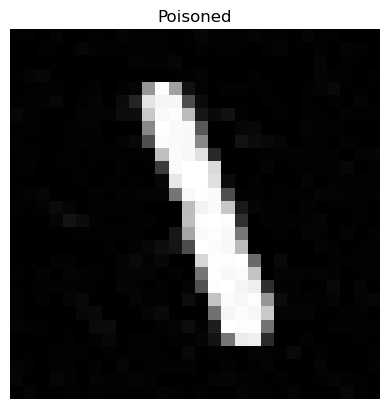

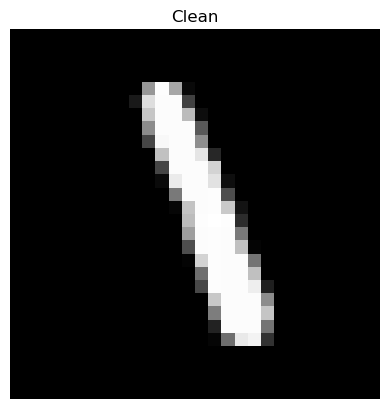

8

In [24]:
plt.imshow(adv_sample.reshape((28, 28)), cmap='gray')
plt.title('Poisoned')
plt.axis('off')
plt.show()
# Some errors at iterations: 551, 717, 827, 1257, 1292 for boundary_5000
plt.imshow(normal_samp.reshape((28, 28)), cmap='gray')
plt.title('Clean')
plt.axis('off')
plt.show()

np.argmax(model.predict(adv_sample.reshape(1,28,28,1)))

In [16]:
adv_model = load_model("models/base_model_cnn_500p.h5")

In [17]:
print("Base model prediction:", np.argmax(model.predict(adv_sample.reshape(1,28,28,1))))
# print(model.predict(adv_sample.reshape(1,28,28,1)))
print("Adversarial model prediction:", np.argmax(adv_model.predict(adv_sample.reshape(1,28,28,1))))
# print(adv_model.predict(adv_sample.reshape(1,28,28,1)))

Base model prediction: 8
Adversarial model prediction: 1


c:\Users\frykm\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


### Attackresultat

In [ ]:
# print("Initial predictions")
# display_top_x(init_image,model,3)

# print("Prediction after a 100 iterations")
# display_top_x(adversarial_img[0],model,3)

contrast_images(adv_sample.reshape(28,28), normal_samp.reshape(28,28))
